#Задача оттока: варианты постановки, возможные способы решения##

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

Давайте поработаем с набором данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %cd /content/drive/MyDrive/Colab Notebooks/ML в бизнесе/Lesson5/

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML в бизнесе/Lesson5/churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [ ]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [ ]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- К вещественным применим стандартизацию

In [ ]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [ ]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [ ]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [ ]:
from sklearn.preprocessing import StandardScaler

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


Ананлогичный пример для вещественного признака (здесь мы не применяем какое-либо преобразование, а просто столбец как есть)

In [ ]:
numr = Pipeline([
                ('selector', NumberSelector(key='CreditScore')),
                ('standard', StandardScaler())
            ])
numr.fit(X_train)
numr.transform(X_test)

array([[-0.55025082],
       [-1.31185979],
       [ 0.57157862],
       ...,
       [ 1.95070838],
       [ 0.29369426],
       [ 0.870047  ]])

Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [ ]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [ ]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

In [ ]:
import random

In [ ]:
random.seed(42)
models =  [xgb.XGBClassifier(), LogisticRegression()]

Обучим модели

In [ ]:
preds = []
for model in models:
  pipeline = Pipeline([
    ('features',feats),
    ('classifier', model)
    ])
  pipeline.fit(X_train, y_train)
  preds.append(pipeline.predict_proba(X_test)[:, 1])

In [ ]:
#наши прогнозы для тестовой выборки
preds

[array([0.25649974, 0.23674226, 0.21990083, ..., 0.24025607, 0.11856069,
        0.09076681], dtype=float32),
 array([0.22805865, 0.3350657 , 0.15347886, ..., 0.28075646, 0.24978477,
        0.12269898])]

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [ ]:
result = {
    'model': [],
    'Best Threshold': [],
    'F-Score': [], 
    'Precision': [], 
    'Recall': []
}

In [ ]:
fscore = []
ix = []
thresholds = []
for i in range(len(preds)):
  precision, recall, threshold = precision_recall_curve(y_test, preds[i])
  thresholds.append(threshold)
  fscore.append((2 * precision * recall) / (precision + recall))
  # locate the index of the largest f score
  ix.append(np.argmax(fscore[i]))
  print('Best params for ', models[i], ': Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[i][ix[i]], 
                                                                          fscore[i][ix[i]],
                                                                          precision[ix[i]],
                                                                          recall[ix[i]]))
  result['model'].append(models[i])
  result['Best Threshold'].append(thresholds[i][ix[i]])
  result['F-Score'].append(fscore[i][ix[i]])
  result['Precision'].append(precision[ix[i]])
  result['Recall'].append(recall[ix[i]])

Best params for  XGBClassifier() : Threshold=0.311235, F-Score=0.640, Precision=0.606, Recall=0.678
Best params for  LogisticRegression() : Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


Запишем результаты

In [ ]:
pd.DataFrame(data=result).sort_values('F-Score', ascending=False)

,model,Best Threshold,F-Score,Precision,Recall
0,XGBClassifier(),0.311235,0.640074,0.606327,0.67780
1,LogisticRegression(),0.289522,0.509700,0.462400,0.56778


#### Вопрос 1: объясните своими словами смысл метрик Precison, Recall *
1. Какова их взаимосвязь и как с ними связан порог вероятности? 
2. Можно ли подобрать порог так, что recall будет равен 1? Что при этом будет с precision
3. Аналогичный вопрос про precision

Ваш ответ здесь:

1. Precision показывает, как часто алгоритм предсказывает класс 1 и оказывается правым, а recall - как много объектов класса 1 алгоритм нашел.
2. Можно подобрать порог, что recall будет равен 1. В таком случае precision будет стремиться к нулю
3. В этом случае recall будет стремиться к нулю.

Отрисуем матрицу ошибок для xgboost

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1767  224]
 [ 165  344]]


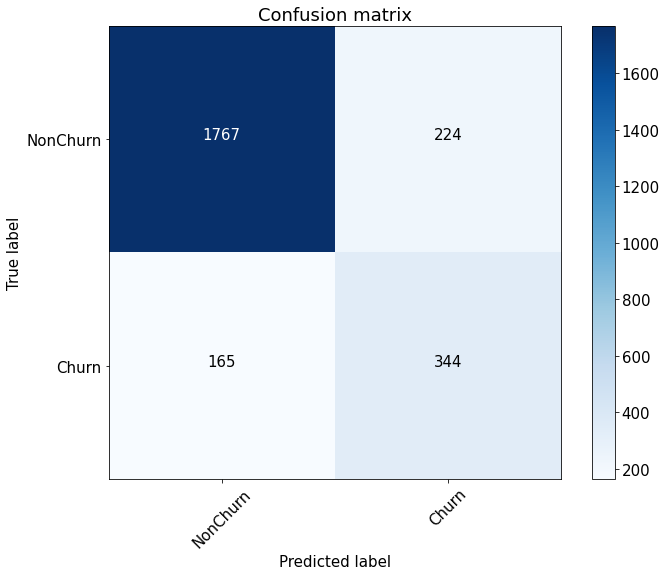

In [ ]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds[0]>thresholds[0][ix[0]])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

<b>Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?</b>

Ваш ответ здесь: 

In [ ]:
def calc_of_econ_eff(cnf_matrix):
  TN = cnf_matrix[0][0]
  FN = cnf_matrix[1][0]
  TP = cnf_matrix[1][1]
  FP = cnf_matrix[0][1]

  retrain_sum = (FP+TP) * 1
  income = TP * 2

  print(income - retrain_sum)  

In [ ]:
calc_of_econ_eff(cnf_matrix)

120


### Пример с перебором параметров с помощью GridSearch

In [ ]:
params = {
    'objective': 'binary:logistic',
    'verbose': 1
}

model_tuned = xgb.XGBClassifier(**params)

In [ ]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', model_tuned)
    ])

In [ ]:
# pipeline.get_params().keys()

Сетка с параметрами

In [ ]:
from sklearn.model_selection import GridSearchCV

params={
        'classifier__max_depth': [3, 4, 5],
        'classifier__learning_rate': [0.1, 0.05, 0.01],
        'classifier__subsample': [0.3, 0.5, 0.7, 1],
        'classifier__min_child_weight': [1, 3, 5],
        'classifier__n_estimators': [100, 150, 200]
        }

Запускаем перебор

In [ ]:
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=6,
                    refit=False)

In [ ]:
search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__learning_rate': 0.05,
 'classifier__max_depth': 4,
 'classifier__min_child_weight': 1,
 'classifier__n_estimators': 200,
 'classifier__subsample': 0.5}

Обучаем модель уже с новыми параметрами (число деревьев увеличим)

In [ ]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(max_depth=4, 
                                          learning_rate=0.05,
                                          min_child_weight=1,
                                          n_estimators=300,
                                          subsample=0.5)), 
     ])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Best Threshold=0.364259, F-Score=0.640, Precision=0.639, Recall=0.640
Confusion matrix, without normalization
[[1807  184]
 [ 184  325]]


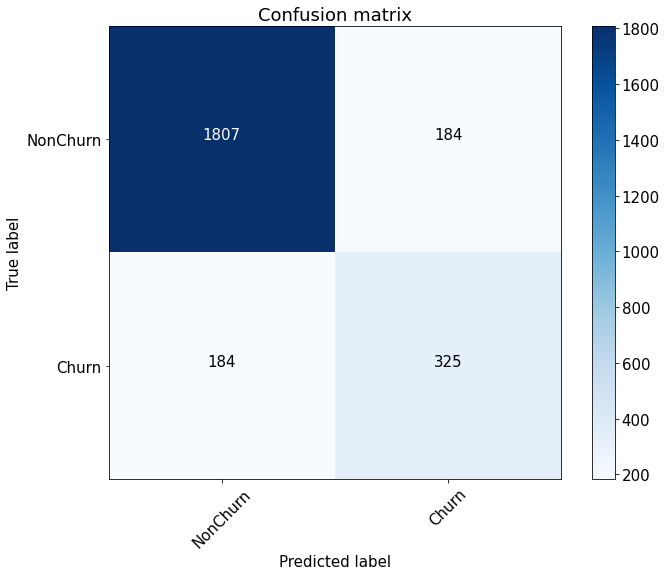

In [ ]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем экономическую эффективность - метрика стала больше

In [ ]:
calc_of_econ_eff(cnf_matrix)

141


Можно заметить, что уменьшение количества False Positive, увеличивает точность и экономическую эффективносьть, что является в данном случае более выгодным. 

In [ ]:
#Функция для калибровки порогового значения
def get_rubles(y_test, probs, cost_offer=2, cost_call=1):
  add_sum =[]
  tresholds = np.linspace(0, 1, 100)
  for i in tresholds:
    cnf_matrix = confusion_matrix(y_test, probs > i)
    add_sum.append(cnf_matrix[1,1]*cost_offer - np.sum(cnf_matrix[:,1]) * cost_call)
  #locate the index of largest f-score
  ix = np.argmax(add_sum)
  print('Best threshold=%.3f, summ=%.3f'%(tresholds[ix], add_sum[ix]))
  return tresholds[ix]

In [ ]:
tr = get_rubles(y_test, preds)

Best threshold=0.657, summ=181.000


**С точки зрения бизнес метрики порог нужно сдвинуть в сторону увеличения точности (precision)**